In [1]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import numpy as np
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
import random
import math

from pathlib import Path

import sys, site
sys.path.insert(0, site.getsitepackages()[0])
import wandb
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count


In [2]:
pip install "gymnasium[other]"

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
#Testing-Wandb
import os

os.environ["WANDB_API_KEY"] ="4c3fbd210d986d0a1d09d50e3e0af6ff012c590c"
# Start a new wandb run to track this script.
os.environ["WANDB_API_KEY"] ="4c3fbd210d986d0a1d09d50e3e0af6ff012c590c"
# Start a new wandb run to track this script.

run = wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    entity="basmaa2003-cairo-university",
    # Set the wandb project where this run will be logged.
    project="my-awesome-project",
    # Track hyperparameters and run metadata.
    config={
        "learning_rate": 0.02,
        "architecture": "CNN",
        "dataset": "CIFAR-100",
        "epochs": 10,
    },
)

# Simulate training.
epochs = 10
offset = random.random() / 5
for epoch in range(2, epochs):
    acc = 1 - 2**-epoch - random.random() / epoch - offset
    loss = 2**-epoch + random.random() / epoch + offset

    # Log metrics to wandb.
    run.log({"acc": acc, "loss": loss})

# Finish the run and upload any remaining data.
run.finish()

wandb: Currently logged in as: basmaa2003 (basmaa2003-cairo-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


acc,▁▃▅█▇▇▇█
loss,█▂▃▂▁▂▂▁
acc,0.95147
loss,0.08817


In [ ]:
video_dir = Path("videos")
video_dir.mkdir(parents=True, exist_ok=True)

def should_record(episode_id: int) -> bool:
    # Record early learning and periodic checkpoints.
    return episode_id == 0 or (episode_id + 1) % 50 == 0

env = gym.make("CartPole-v1", render_mode="rgb_array")
env = RecordVideo(
    env,
    video_folder=str(video_dir),
    episode_trigger=should_record,
    name_prefix="cartpole-training",
)

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)


# To ensure reproducibility during training, you can fix the random seeds
# by uncommenting the lines below. This makes the results consistent across
# runs, which is helpful for debugging or comparing different approaches.
#
# That said, allowing randomness can be beneficial in practice, as it lets
# the model explore different training trajectories.


seed = 42
random.seed(seed)
torch.manual_seed(seed)
env.reset(seed=seed)
env.action_space.seed(seed)
env.observation_space.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [5]:
#implement dqn algorithm

class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [6]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer

BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.01
EPS_DECAY = 2500
TAU = 0.005
LR = 3e-4

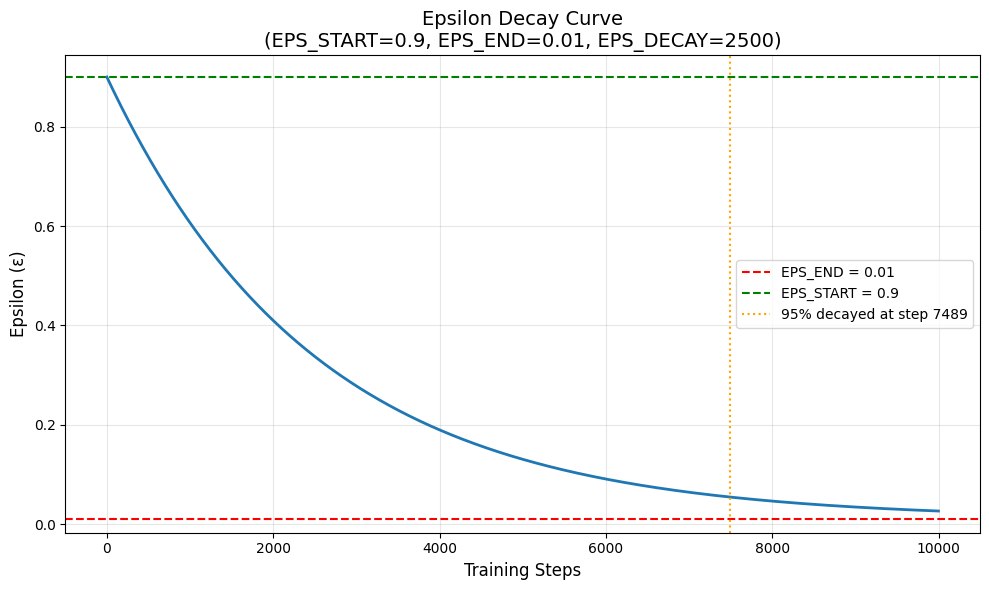

In [7]:
def plot_epsilon_decay(eps_start=0.9, eps_end=0.01, eps_decay=2500, max_steps=10000):
    """
    Plot the epsilon decay curve for epsilon-greedy exploration.
    
    Parameters:
    - eps_start: Starting value of epsilon
    - eps_end: Final value of epsilon
    - eps_decay: Rate of exponential decay (higher = slower decay)
    - max_steps: Number of steps to plot
    """
    steps = np.arange(0, max_steps)
    epsilon_values = eps_end + (eps_start - eps_end) * np.exp(-steps / eps_decay)
    
    plt.figure(figsize=(10, 6))
    plt.plot(steps, epsilon_values, linewidth=2)
    plt.axhline(y=eps_end, color='r', linestyle='--', label=f'EPS_END = {eps_end}')
    plt.axhline(y=eps_start, color='g', linestyle='--', label=f'EPS_START = {eps_start}')
    
    # Mark where epsilon reaches approximately eps_end + 5% of range
    threshold = eps_end + 0.05 * (eps_start - eps_end)
    step_at_threshold = -eps_decay * np.log((threshold - eps_end) / (eps_start - eps_end))
    plt.axvline(x=step_at_threshold, color='orange', linestyle=':', 
                label=f'95% decayed at step {int(step_at_threshold)}')
    
    plt.xlabel('Training Steps', fontsize=12)
    plt.ylabel('Epsilon (ε)', fontsize=12)
    plt.title(f'Epsilon Decay Curve\n(EPS_START={eps_start}, EPS_END={eps_end}, EPS_DECAY={eps_decay})', 
              fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

plot_epsilon_decay(eps_start=EPS_START, eps_end=EPS_END, eps_decay=EPS_DECAY, max_steps=10000)


In [8]:


# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [9]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Complete


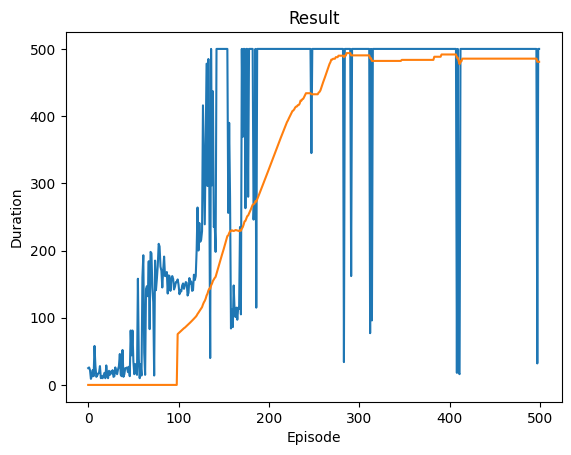

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [10]:
if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 600
else:
    num_episodes = 500

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

In [12]:
import base64
from IPython.display import HTML

def show_latest_video(video_directory: Path = video_dir) -> HTML:
    video_files = sorted(video_directory.glob("*.mp4"))
    if not video_files:
        raise FileNotFoundError("No recorded CartPole episodes yet.")
    latest_video = video_files[-1]
    video_b64 = base64.b64encode(latest_video.read_bytes()).decode("ascii")
    return HTML(
        f'<video width="640" controls>'
        f'<source src="data:video/mp4;base64,{video_b64}" type="video/mp4" />'
        "Your browser does not support the video tag."
        "</video>"
)

show_latest_video()

NameError: name 'math' is not defined

In [ ]:
# Train DQN on Acrobot-v1 (notebook cell)
# This cell re-uses the DQN class, ReplayMemory and optimize_model implementation above.
# It runs a short training job and saves the final model to `models/`.

import os
import math
import torch
import wandb
from gymnasium.wrappers import RecordVideo
from pathlib import Path

# Optional: start a wandb run (remove if you prefer not to log)
run = wandb.init(project='rl-dqn', name='Acrobot-dqn-notebook', reinit=True, config={
    'env': 'Acrobot-v1', 'algo': 'dqn'
})

env_name = 'Acrobot-v1'

# --- Video recording setup ---
acrobot_video_dir = Path("videos/acrobot")
acrobot_video_dir.mkdir(parents=True, exist_ok=True)

def should_record_acrobot(episode_id: int) -> bool:
    # Record early learning and periodic checkpoints.
    return episode_id == 0 or (episode_id + 1) % 50 == 0

env = gym.make(env_name, render_mode='rgb_array')
env = RecordVideo(
    env,
    video_folder=str(acrobot_video_dir),
    episode_trigger=should_record_acrobot,
    name_prefix="acrobot-training",
)
# --- End video recording setup ---

# seeds for reproducibility
seed = 42
random.seed(seed)
torch.manual_seed(seed)
try:
    env.reset(seed=seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
except Exception:
    pass

obs, _ = env.reset()
n_observations = len(obs)
n_actions = env.action_space.n

# Create networks and optimizer (re-using notebook's DQN class)
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

# Replay memory (reuse class above)
memory = ReplayMemory(10000)

# overwrite globals used by existing helper functions (select_action/optimize_model)
steps_done = 0

# local select_action redefinition to use shared EPS params
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

# A compact local optimize using the notebook's optimize_model function style
def optimize_local():
    if len(memory) < BATCH_SIZE:
        return None
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()
    return loss.item()

# Training loop (short run for notebook)
num_episodes = 200
acrobot_episode_durations = []

# --- Plotting setup ---
plt.ion()
fig, ax = plt.subplots(figsize=(10, 5))
is_ipython = 'inline' in matplotlib.get_backend()

def plot_acrobot_durations(show_result=False):
    ax.clear()
    durations_t = torch.tensor(acrobot_episode_durations, dtype=torch.float)
    ax.set_title('Training Acrobot...' if not show_result else 'Result')
    ax.set_xlabel('Episode')
    ax.set_ylabel('Duration')
    ax.plot(durations_t.numpy(), label='Episode Duration')
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        ax.plot(means.numpy(), label='100-ep Average')
    ax.legend()
    plt.pause(0.001)
    if is_ipython:
        display.display(fig)
        display.clear_output(wait=True)
# --- End plotting setup ---


for i_episode in range(num_episodes):
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    total_reward = 0.0
    t = 0
    while True:
        action = select_action(state)
        obs, reward, terminated, truncated, _ = env.step(int(action.item()))
        done = terminated or truncated
        reward_t = torch.tensor([reward], device=device)
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)

        memory.push(state, action, next_state, reward_t)
        state = next_state
        total_reward += float(reward)
        t += 1

        loss = optimize_local()
        if loss is not None:
            run.log({'train/loss': loss, 'train/eps': EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY), 'train/step': steps_done})

        # soft update target
        target_net_state = target_net.state_dict()
        policy_state = policy_net.state_dict()
        for key in policy_state:
            target_net_state[key] = policy_state[key] * TAU + target_net_state[key] * (1 - TAU)
        target_net.load_state_dict(target_net_state)

        if done:
            acrobot_episode_durations.append(t + 1)
            plot_acrobot_durations()
            run.log({'train/episode_length': t, 'train/episode_reward': total_reward, 'train/episode': i_episode})
            break

    if (i_episode + 1) % 50 == 0:
        print(f"Episode {i_episode+1}/{num_episodes} — last length: {t} — avg(last 50): {sum(acrobot_episode_durations[-50:]) / min(len(acrobot_episode_durations),50):.2f}")

# Final plot
plot_acrobot_durations(show_result=True)
plt.ioff()

# Save model
os.makedirs('models', exist_ok=True)
model_path = f"models/{env_name}_dqn_notebook.pt"
torch.save({'policy_state_dict': policy_net.state_dict()}, model_path)
print(f"Saved model to {model_path}")
run.save(model_path, policy="end")
run.finish()
env.close()


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: Paste an API key from your profile and hit enter:wandb: Paste an API key from your profile and hit enter:wandb: Paste an API key from your profile and hit enter:wandb: Paste an API key from your profile and hit enter:wandb: Paste an API key from your profile and hit enter:wandb: Paste an API key from your profile and hit enter:wandb: Paste an API key from your profile and hit enter:wandb: Paste an API key from your profile and hit enter:wandb: Paste an API key from your profile and hit enter:

In [ ]:
# Display the latest Acrobot video
show_latest_video(video_directory=acrobot_video_dir)


In [ ]:
# Train DQN on MountainCar-v0

import os
import math
import torch
import wandb
from gymnasium.wrappers import RecordVideo
from pathlib import Path

# --- Environment and Video Setup ---
env_name = 'MountainCar-v0'
mountaincar_video_dir = Path("videos/mountaincar")
mountaincar_video_dir.mkdir(parents=True, exist_ok=True)

def should_record_mountaincar(episode_id: int) -> bool:
    return episode_id > 0 and (episode_id + 1) % 50 == 0

env = gym.make(env_name, render_mode='rgb_array')
env = RecordVideo(
    env,
    video_folder=str(mountaincar_video_dir),
    episode_trigger=should_record_mountaincar,
    name_prefix="mountaincar-training",
)

# --- WandB and Agent Setup ---
run = wandb.init(project='rl-dqn', name='MountainCar-dqn-notebook', reinit=True, config={
    'env': env_name, 'algo': 'dqn'
})

seed = 42
random.seed(seed)
torch.manual_seed(seed)
try:
    env.reset(seed=seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
except Exception:
    pass

obs, _ = env.reset()
n_observations = len(obs)
n_actions = env.action_space.n

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)
steps_done = 0

# --- Plotting Setup ---
plt.ion()
fig_mc, ax_mc = plt.subplots(figsize=(10, 5))
mountaincar_episode_durations = []

def plot_mountaincar_durations(show_result=False):
    ax_mc.clear()
    durations_t = torch.tensor(mountaincar_episode_durations, dtype=torch.float)
    ax_mc.set_title('Training MountainCar...' if not show_result else 'Result')
    ax_mc.set_xlabel('Episode')
    ax_mc.set_ylabel('Duration')
    ax_mc.plot(durations_t.numpy(), label='Episode Duration')
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        ax_mc.plot(means.numpy(), label='100-ep Average')
    ax_mc.legend()
    plt.pause(0.001)
    if 'inline' in matplotlib.get_backend():
        display.display(fig_mc)
        display.clear_output(wait=True)

# --- Training Loop ---
num_episodes = 1000  # MountainCar can be hard to solve
for i_episode in range(num_episodes):
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    t = 0
    while True:
        action = select_action(state)
        obs, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated
        
        # Reward shaping: give a bonus for reaching the goal
        if terminated:
            reward += 100

        reward_t = torch.tensor([reward], device=device)
        
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)

        memory.push(state, action, next_state, reward_t)
        state = next_state
        t += 1

        loss = optimize_local()
        if loss is not None:
            run.log({'mc/loss': loss})

        if done:
            mountaincar_episode_durations.append(t + 1)
            plot_mountaincar_durations()
            run.log({'mc/episode_length': t + 1, 'mc/episode': i_episode})
            break
    
    if (i_episode + 1) % 50 == 0:
        print(f"Episode {i_episode+1}/{num_episodes} — last length: {t+1}")

plot_mountaincar_durations(show_result=True)
plt.ioff()
run.finish()
env.close()
print("MountainCar training complete.")


mc/episode,▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
mc/episode_length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mc/loss,▂▂█▄▃▁▂▁▅▁▂▁█▄▂▁▂▁▁▁▁▂▂▁▁▃▃▁▁▂▁▂▁▂▁▁▁▁▁▁
mc/episode,999
mc/episode_length,201
mc/loss,0.0


MountainCar training complete.



In [ ]:
# Display the latest MountainCar video
show_latest_video(video_directory=mountaincar_video_dir)


## Pendulum-v1 (Continuous Action Space)

The standard DQN algorithm is designed for discrete action spaces and will not work directly with the `Pendulum-v1` environment, which has a continuous action space. To handle this, one would typically:
1.  **Discretize the action space**: Convert the continuous range into a set of discrete actions.
2.  **Use a different algorithm**: Employ an actor-critic method like DDPG or TD3, which are designed for continuous control.

Below is an example of how you might train an agent by discretizing the action space. This is a simplification and may not yield optimal results, but it allows the DQN to be applied.


In [ ]:
# Train DQN on Pendulum-v1 with a Discretized Action Space

import numpy as np
from gymnasium import ActionWrapper, spaces

class DiscretizeAction(ActionWrapper):
    def __init__(self, env, n_actions):
        super().__init__(env)
        self.n_actions = n_actions
        self.action_space = spaces.Discrete(n_actions)
        self.continuous_actions = np.linspace(
            self.env.action_space.low[0], self.env.action_space.high[0], n_actions
        )

    def action(self, action):
        return [self.continuous_actions[action]]

# --- Environment and Video Setup ---
env_name = 'Pendulum-v1'
pendulum_video_dir = Path("videos/pendulum")
pendulum_video_dir.mkdir(parents=True, exist_ok=True)

def should_record_pendulum(episode_id: int) -> bool:
    return episode_id > 0 and (episode_id + 1) % 50 == 0

env = gym.make(env_name, render_mode='rgb_array')
env = DiscretizeAction(env, n_actions=11)  # Discretize torque into 11 distinct actions
env = RecordVideo(
    env,
    video_folder=str(pendulum_video_dir),
    episode_trigger=should_record_pendulum,
    name_prefix="pendulum-training",
)

# --- WandB and Agent Setup ---
run = wandb.init(project='rl-dqn', name='Pendulum-dqn-notebook', reinit=True, config={
    'env': env_name, 'algo': 'dqn', 'n_actions_discrete': 11
})

seed = 42
random.seed(seed)
torch.manual_seed(seed)
try:
    env.reset(seed=seed)
    env.action_space.seed(seed)
except Exception:
    pass

obs, _ = env.reset()
n_observations = len(obs)
n_actions = env.action_space.n

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)
steps_done = 0

# --- Plotting Setup ---
plt.ion()
fig_p, ax_p = plt.subplots(figsize=(10, 5))
pendulum_episode_rewards = []

def plot_pendulum_rewards(show_result=False):
    ax_p.clear()
    rewards_t = torch.tensor(pendulum_episode_rewards, dtype=torch.float)
    ax_p.set_title('Training Pendulum...' if not show_result else 'Result')
    ax_p.set_xlabel('Episode')
    ax_p.set_ylabel('Total Reward')
    ax_p.plot(rewards_t.numpy(), label='Episode Reward')
    if len(rewards_t) >= 100:
        means = rewards_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        ax_p.plot(means.numpy(), label='100-ep Average')
    ax_p.legend()
    plt.pause(0.001)
    if 'inline' in matplotlib.get_backend():
        display.display(fig_p)
        display.clear_output(wait=True)

# --- Training Loop ---
num_episodes = 500
for i_episode in range(num_episodes):
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    total_reward = 0
    t = 0
    while True:
        action = select_action(state)
        obs, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated
        
        reward_t = torch.tensor([reward], device=device)
        
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)

        memory.push(state, action, next_state, reward_t)
        state = next_state
        total_reward += reward
        t += 1

        loss = optimize_local()
        if loss is not None:
            run.log({'pendulum/loss': loss})

        if done:
            pendulum_episode_rewards.append(total_reward)
            plot_pendulum_rewards()
            run.log({'pendulum/episode_reward': total_reward, 'pendulum/episode': i_episode})
            break
    
    if (i_episode + 1) % 50 == 0:
        print(f"Episode {i_episode+1}/{num_episodes} — last reward: {total_reward:.2f}")

plot_pendulum_rewards(show_result=True)
plt.ioff()
run.finish()
env.close()
print("Pendulum training complete.")


pendulum/episode,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇███
pendulum/episode_reward,▆█▆▆▄▃▂▃▄▄▃▃▂▂▃▂▂▂▂▂▂▂▂▂▁▃▁▃▄▁▃▄▁▂▂▁▂▂▁▂
pendulum/loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
pendulum/episode,499
pendulum/episode_reward,-1437.93039
pendulum/loss,7e-05


Pendulum training complete.



In [ ]:
# Display the latest Pendulum video
show_latest_video(video_directory=pendulum_video_dir)
